<a id='ImpPkg'></a>
# 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice
# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [3]:
def Coefpresplot_bar2(regtable1, mixtable1,regtable2, mixtable2, intercept=False, barcol1='#000000',barcol2='#000000', title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0 ):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)
            
    # Set seaborn style for the plot
    sns.set(style='white')
    
    bar_sep= 0.25
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not   
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients
    if intercept == True:
        XLim = (0, len(regtable1.columns) + 2)
        YLim = (round_to_5(np.min([mixtable1,mixtable2]))-0.2, round_to_5(np.max([mixtable1,mixtable2]))+0.2)
    else:
        XLim = (0, len(regtable1.columns) +1)
        YLim = (round_to_5(np.min([mixtable1,mixtable2]))-0.2, round_to_5(np.max([mixtable1,mixtable2]))+0.2)
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients

    if intercept == True:
        Coefficients = regtable1.columns
    else:
        if len(regtable1.columns)<len(mixtable1):
            Coefficients = regtable1.columns
        else:
            Coefficients = regtable1.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    # Color for conditions 1 and 2
    colourlist1 = [barcol1] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    colourlist2 = [barcol2] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        # Plot condition 1
        ax.bar(position-bar_sep, regtable1.loc['coefficient', Coefficient], width=0.4,color=colourlist1[position-1],hatch=r'//')
        ax.errorbar(position-bar_sep, regtable1.loc['coefficient', Coefficient],
                    yerr=regtable1.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        # Plot condition 2
        ax.bar(position+bar_sep, regtable2.loc['coefficient', Coefficient], width=0.4,color=colourlist2[position-1],hatch=r'//')
        ax.errorbar(position+bar_sep, regtable2.loc['coefficient', Coefficient],
                    yerr=regtable2.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        
   # Plot dots for the individual coefficients
    # Assumuing that mixtable1 and mixtable2 have exactly the same number of elements 
    
    if intercept == True:
        coef_num = range(0,len(mixtable1)) 
    else:
        coef_num = range(1,len(mixtable1))
        
    for i in coef_num:
        # Plot dots condition 1
        part_coefs = mixtable1[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(position_parts-bar_sep+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")

        # Plot dots condition 1
        part_coefs = mixtable2[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(position_parts+bar_sep+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")
        

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable1.columns, rotation=0)        
    else:
        if len(regtable1.columns)<len(mixtable1):
            ax.set_xticklabels(regtable1.columns, rotation=0)
        else:    
            ax.set_xticklabels(regtable1.columns[1:], rotation=0)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Regression Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    
    patch1 = mpatches.Patch(facecolor=colourlist1[position-1],hatch=r'//', label='Most')
    patch2 = mpatches.Patch(facecolor=colourlist2[position-1],hatch=r'//', label='Few')

    leg = plt.legend(handles=[patch1,patch2],fontsize=14)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    
    sns.despine()

In [4]:
def regtable(fix, fix_se, names):
    fixed_betas = DF(np.array(fix)); fixed_betas = fixed_betas.transpose(); fixed_betas.columns = names
    fixed_betas.loc[1] = np.array(fix_se)
    fixed_betas.loc[2] = fixed_betas.loc[0] - (fixed_betas.loc[1]*1.96)
    fixed_betas.loc[3] = fixed_betas.loc[0] + (fixed_betas.loc[1]*1.96)
    fixed_betas.index = ['coefficient', 'se', 'CImin', 'CImax']
    return fixed_betas

In [5]:
def ttestprint (Choice_Like_hmodel_table,Choice_Dislike_hmodel_table, mix_Choice_Like_model,mix_Choice_Dislike_model):

    if len(Choice_Like_hmodel_table.columns) >= len(mix_Choice_Like_model):
        print ("Mismatch")
    
    
    print ("---------------- SIGNIFICANT FACTOR ----------------------")
    
    for i in range(len(Choice_Like_hmodel_table.columns)):
        param_name = Choice_Like_hmodel_table.columns[i]
        part_coefs_like = mix_Choice_Like_model[ i ]
    
        [s, p] = stats.ttest_1samp(part_coefs_like,0)
        if p<0.01:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "**")
        elif p<0.05:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "*")
        else:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)))
    
      
        part_coefs_dislike = mix_Choice_Dislike_model[ i ]
    
        [s, p] = stats.ttest_1samp(part_coefs_dislike,0)
        
        if p<0.01:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) + "**")
        elif p<0.05:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) + "*")
        else:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)))
        
        
    print ("---------------- COMPARE [ LIKE - DISLIKE ] ----------------------")
    
    for i in range(len(Choice_Like_hmodel_table.columns)):
        param_name = Choice_Like_hmodel_table.columns[i]
        part_coefs_like = mix_Choice_Like_model[ i ]
        part_coefs_dislike = mix_Choice_Dislike_model[ i ]
                
        diff = mean(part_coefs_like) - mean(part_coefs_dislike)
        [s, p] = stats.ttest_rel(part_coefs_like,part_coefs_dislike)
        
        if p<0.01:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "**" )
        elif p<0.05:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "*" )
        else:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) )
        
    

In [6]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [7]:
def splitBy(data_exp1, Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit'],Splits_variables = ['Conf', 'tGSF','tDDT']):
    
    median_matrix=[]
    median_matrix_aux=[]
    median_matrix_aux_cond=[]
    Split_cols = []
    
    for h in range(len(Splits_variables)):
        median_matrix=[]
        for i in unique(data_exp1["Part"]):
            median_matrix_aux=[]
    
            for j in unique(data_exp1["BlockCond"]):
                #median_matrix_aux_cond=[]
    
                #Extract data by participant and BlockCond (1: Like, 2: Dislike)
                Splitdata = data_exp1.loc[data_exp1['Part'] == i]
                Splitdata = Splitdata.loc[Splitdata['BlockCond'] == j]
                
                # Select the column to split
                Splitdata = Splitdata.loc[:,['TrialN',Splits_variables[h]]]
                SplitSort = Splitdata.values
                # Sort for confidence column
                SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
                #print(SplitSort)
                lenPart = len(Splitdata)
                #print(lenPart)
                # Generate column with median order
                median_low = [0] * int (lenPart/2)
    
                if len(SplitSort) != 2*len(median_low):
                    median_high=  [1] * int(len(SplitSort)-len(median_low))
                else: median_high = [1] * int (lenPart/2)
            
                median_split_order = median_low + median_high
                #Attach split median order column (1 and 0)
                median_aux= np.column_stack((SplitSort,median_split_order))
                #Sort back to trial number
                SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
                #print(len(SplitSorted))
                
                for kk in range(len(SplitSorted)): 
                    if len(median_matrix_aux) == 0 :
                        median_matrix_aux = SplitSorted[0]
                    else:
                        median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted[kk]])
            
            
            #print(["participant "+ str(i)+ " done"])
            # sort after adding both conditions    
            median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]
            
            #Extract only the column with the median split information
            median_matrix_aux = median_matrix_aux[:,2]
            
            #append to median matrix for the participants
            for k in range(len(median_matrix_aux)):    
                median_matrix.append(median_matrix_aux [k])
        
        median_matrix = pd.DataFrame(median_matrix,columns=[Splits_headers[h]])
        #print(len (median_matrix))
        #add new column (new split variable columns) to the split matrix
        if  h == 0:
            Split_cols = median_matrix
        else:
            Split_cols = pd.concat([Split_cols,median_matrix ],axis =1)   
    
    return Split_cols

## LOAD

In [8]:
# Load data all participants

data_exp1 = pd.read_csv('/Users/pradyumna/Documents/GiTs/PF2019/Data/DataPerceptualFramingNotebook_v1.csv') 

for i in [1,13,16,20,31]:
    data_exp1 = data_exp1[(data_exp1.Part != i)]
print (data_exp1["Part"].unique())
print ('Number of participants: ' + str(len(data_exp1["Part"].unique())))

[ 2  3  4  5  6  7  8  9 10 11 12 14 15 17 18 19 21 22 23 24 25 26 27 28
 29 30 32 33]
Number of participants: 28


## * We eliminate participant 31 from perceptual analysis*

In [9]:
data_exp1=data_exp1.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})


## Add missing zScored values

In [10]:
data_exp1["zGSF"] = z_score1(data_exp1,'Part',"GSF")
data_exp1["zDDT"] = z_score1(data_exp1,'Part',"DDT")
data_exp1["AbsDDT"] = abs(data_exp1["DDT"])
data_exp1["zAbsDDT"] = z_score1(data_exp1,'Part',"AbsDDT")

data_exp1["TotVal"] = data_exp1['LVal']+ data_exp1['RVal']
data_exp1["zTotVal"] = z_score1(data_exp1,'Part',"TotVal")

data_exp1["ChosenVal"] = data_exp1['RVal']*data_exp1['Choice']+ data_exp1['LVal']*(1-data_exp1['Choice'])
data_exp1["UnchosenVal"] = data_exp1['LVal']*data_exp1['Choice']+ data_exp1['RVal']*(1-data_exp1['Choice'])
data_exp1["zChosenVal"] = z_score1(data_exp1,'Part',"ChosenVal")
data_exp1["zUnchosenVal"] = z_score1(data_exp1,'Part',"UnchosenVal")


## Change the name of the BlockCond

In [11]:
# Change so everything is equal
data_exp1 = data_exp1.replace('NEXTLESS', 'MORE')
data_exp1 = data_exp1.replace('NEXTMORE', 'LESS')
data_exp1['BlockCond'].unique()

# Change so everything is equal
data_exp1 = data_exp1.replace('MORE', 1)
data_exp1 = data_exp1.replace('LESS', 2)
data_exp1['BlockCond'].unique()

array([1, 2])

## Add correct variable

In [12]:
Correct = []
for i in range(len(data_exp1)):
    if data_exp1.BlockCond[i] == 1:
        if (data_exp1.Choice[i] == 1 and (data_exp1.LVal[i] < data_exp1.RVal[i])) or (data_exp1.Choice[i] == 0 and (data_exp1.LVal[i] > data_exp1.RVal[i])):
            Correct.append(1)
        else:
            Correct.append(0)
    if data_exp1.BlockCond[i] == 2:
        if (data_exp1.Choice[i] == 1 and (data_exp1.LVal[i] > data_exp1.RVal[i])) or (data_exp1.Choice[i] == 0 and (data_exp1.LVal[i] < data_exp1.RVal[i])):
            Correct.append(1)
        else:
            Correct.append(0)

data_exp1["Correct"] = Correct

## Add Splits variable

In [13]:
data_splits = splitBy(data_exp1, Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit'],Splits_variables = ['Conf', 'GSF','DDT'])
#data_exp11 = splitBy(data_exp1.loc[data_exp1['Part'] == 1], ['ConfSplit'], ['Conf'])


In [14]:
data_exp1['ConfSplit'] = data_splits['ConfSplit'].values
data_exp1['GSFSplit'] = data_splits['GSFMedSplit'].values
data_exp1['DDTSplit'] = data_splits['DDTMedSplit'].values

## Load data to R

In [15]:
%R -i data_exp1


/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [16]:
%%R
library(lme4)
#library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

In [17]:
%R
##Change Column name for better regression presentation
#colnames(data_exp1)[which(names(data_exp1) == "zChoiceRT")] <- "zRT"
#colnames(data_exp1)[which(names(data_exp1) == "ChoiceRT")] <- "RT"

In [18]:
%%R
# Separating the data for both conditions 
data_exp1_Like <- data_exp1[ which(data_exp1$BlockCond=='1'), ]
data_exp1_DisLike <- data_exp1[ which(data_exp1$BlockCond=='2'), ]

# Regression

## Choice ~ BehavioralParams + DDT

### LESS Condition

In [19]:
%%R

if (file.exists('SavedModels/Models_32Part/HModel_Choice_Less_GlamEx_m2.rda')){
    load('SavedModels/Models_32Part/HModel_Choice_Less_GlamEx_m2.rda')   
    print('  Found old parameter estimates in "SavedModels/". Skipping estimation...')
}
else{
# Fit binomial hierarchical model
Choice_Dislike_hmodel =  glmer(Choice ~  zDVal + zConf + zTotVal + zDDT + zDVal:zConf + (zDVal + zConf + zTotVal + zDDT + zDVal:zConf | Part), data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (Choice_Dislike_hmodel)
}

glmer(formula = Choice ~ zDVal + zConf + zTotVal + zDDT + zDVal:zConf + 
    (zDVal + zConf + zTotVal + zDDT + zDVal:zConf | Part), data = data_exp1_DisLike, 
    family = "binomial", control = glmerControl(optimizer = "optimx", 
        optCtrl = list(method = "nlminb")))
            coef.est coef.se
(Intercept) -0.91     0.15  
zDVal       -1.75     0.14  
zConf       -1.04     0.17  
zTotVal      0.05     0.07  
zDDT         2.21     0.22  
zDVal:zConf -0.55     0.11  

Error terms:
 Groups   Name        Std.Dev. Corr                          
 Part     (Intercept) 0.70                                   
          zDVal       0.53      0.39                         
          zConf       0.78      0.27  0.10                   
          zTotVal     0.14      0.45  0.65  0.17             
          zDDT        1.03     -0.19  0.20 -0.76 -0.09       
          zDVal:zConf 0.36      0.22  0.98  0.04  0.59  0.32 
 Residual             1.00                                   
---
number of

In [20]:
%%R
# If we want to see individually the value of each coefficient for the participants
#coef(Choice_Dislike_hmodel)

NULL


In [21]:
%%R
#Extract parameters
fix_Choice_Dislike_hmodel <- fixef(Choice_Dislike_hmodel)
fix_se_Choice_Dislike_hmodel <- sqrt(diag(vcov(Choice_Dislike_hmodel)))
names_Choice_Dislike_hmodel <- names(fix_Choice_Dislike_hmodel)

# Extract mixed effect paramters
mix_Choice_Dislike_model <- coef(Choice_Dislike_hmodel)

summary(Choice_Dislike_hmodel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Choice ~ zDVal + zConf + zTotVal + zDDT + zDVal:zConf + (zDVal +  
    zConf + zTotVal + zDDT + zDVal:zConf | Part)
   Data: data_exp1_DisLike
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  2337.6   2502.8  -1141.8   2283.6     3333 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-71.215  -0.337  -0.079   0.290   9.860 

Random effects:
 Groups Name        Variance Std.Dev. Corr                         
 Part   (Intercept) 0.49356  0.7025                                
        zDVal       0.28103  0.5301    0.39                        
        zConf       0.60878  0.7802    0.27  0.10                  
        zTotVal     0.01865  0.1366    0.45  0.65  0.17            
        zDDT        1.05630  1.0278   -0.19  0.20 -0.76 -0.09      
        zDVal:zConf 0.1272

In [22]:
%R -o fix_Choice_Dislike_hmodel -o fix_se_Choice_Dislike_hmodel -o names_Choice_Dislike_hmodel -o mix_Choice_Dislike_model

#Generate table with parameters to plot
Choice_Dislike_hmodel_table = regtable(fix_Choice_Dislike_hmodel, fix_se_Choice_Dislike_hmodel, names_Choice_Dislike_hmodel)
Choice_Dislike_hmodel_table.columns = [ '(inter)','ΔDots', 'Confidence', "ΣDots", "DDT", "ΔVal\n x   \nConf"]

# Extract table containing mixed effects for the model
mix_Choice_Dislike_model = mix_Choice_Dislike_model[0]

#Coefpresplot(Choice_Dislike_hmodel_table, title='', ticklabsize=16, size='narrow', ymultiple=0.5, n_ET_predictors=2)
#[i.set_color('#03719c') for i in plt.gca().get_xticklabels()[4:]]
#plt.savefig('../../figures/CoM_cut_slow_1.png', dpi=600, bbox_inches='tight')

### MORE Condition

In [23]:
%%R
if (file.exists('SavedModels/Models_32Part/HModel_Choice_More_GlamEx_m2.rda')){
    load('SavedModels/Models_32Part/HModel_Choice_More_GlamEx_m2.rda')   
    print('  Found old parameter estimates in "SavedModels/". Skipping estimation...')
}
else{
# Fit binomial hierarchical model
Choice_Like_hmodel =  glmer(Choice ~  zDVal + zConf + zTotVal + zDDT + zDVal:zConf + (zDVal + zConf + zTotVal + zDDT + zDVal:zConf | Part), data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (Choice_Like_hmodel)
}

glmer(formula = Choice ~ zDVal + zConf + zTotVal + zDDT + zDVal:zConf + 
    (zDVal + zConf + zTotVal + zDDT + zDVal:zConf | Part), data = data_exp1_Like, 
    family = "binomial", control = glmerControl(optimizer = "optimx", 
        optCtrl = list(method = "nlminb")))
            coef.est coef.se
(Intercept)  0.47     0.12  
zDVal        1.71     0.13  
zConf       -0.37     0.13  
zTotVal     -0.06     0.07  
zDDT         1.89     0.19  
zDVal:zConf  0.72     0.09  

Error terms:
 Groups   Name        Std.Dev. Corr                          
 Part     (Intercept) 0.55                                   
          zDVal       0.50      0.15                         
          zConf       0.59      0.47 -0.37                   
          zTotVal     0.21      0.66 -0.17  0.96             
          zDDT        0.89     -0.03 -0.02 -0.62 -0.58       
          zDVal:zConf 0.21     -0.24  0.09 -0.42 -0.42  0.38 
 Residual             1.00                                   
---
number of ob

In [24]:
%%R
#Extract regression parameters
fix_Choice_Like_hmodel <- fixef(Choice_Like_hmodel)
# Calculate standard error for paramters
fix_se_Choice_Like_hmodel <- sqrt(diag(vcov(Choice_Like_hmodel)))
names_Choice_Like_hmodel <- names(Choice_Like_hmodel)
summary(Choice_Like_hmodel)

# Extract mixed effect paramters
mix_Choice_Like_model <- coef(Choice_Like_hmodel)


In [25]:
%R -o fix_Choice_Like_hmodel -o fix_se_Choice_Like_hmodel -o mix_Choice_Like_model
 #-o names_Choice_Like_hmodel 

# we use the same names that were defined for the predictors that in the dislike case, since they are the same in both cases
Choice_Like_hmodel_table = regtable(fix_Choice_Like_hmodel, fix_se_Choice_Like_hmodel, names_Choice_Dislike_hmodel)
Choice_Like_hmodel_table.columns = [ '(Intercept)','ΔDots', 'Confidence', "ΣDots", "DDT", "ΔVal\n x   \nConf"]
mix_Choice_Like_model = mix_Choice_Like_model[0]

#Coefpresplot(Choice_Like_hmodel_table, title='', ticklabsize=16, size='narrow', ymultiple=0.5, n_ET_predictors=2)
#[i.set_color('#03719c') for i in plt.gca().get_xticklabels()[4:]]
#plt.savefig('../../figures/CoM_cut_slow_1.png', dpi=600, bbox_inches='tight')


### Plotting both conditions

In [26]:
#Coefpresplot2(Choice_Like_hmodel_table,Choice_Dislike_hmodel_table, title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0)

In [27]:
#Coefpresplot_bar(Choice_Dislike_hmodel_table, mix_Choice_Dislike_model, barcol ='#AC5255' ,title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0, ylimits = (-3,4))
#Coefpresplot_bar(Choice_Like_hmodel_table, mix_Choice_Like_model, barcol ='#4F6A9A' ,title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0, ylimits = (-3,4))

In [28]:
Choice_Like_hmodel_table

,(Intercept),ΔDots,Confidence,ΣDots,DDT,ΔVal x Conf
coefficient,0.471421,1.705604,-0.366436,-0.062310,1.890780,0.722801
se,0.120885,0.126104,0.134021,0.069932,0.192922,0.092991
CImin,0.234486,1.458440,-0.629117,-0.199377,1.512653,0.540539
CImax,0.708355,1.952768,-0.103755,0.074756,2.268907,0.905063


In [29]:
mix_Choice_Like_model

(Intercept),zDVal,zConf,zTotVal,zDDT,zDVal:zConf
0.765990,1.761833,0.560508,0.275556,0.535033,0.534782
0.508393,1.534746,-0.434960,-0.092912,1.976638,0.687485
1.497450,1.999842,0.539679,0.343402,0.610663,0.400467
0.358230,1.713338,-0.172333,-0.006138,1.555277,0.709736
...,...,...,...,...,...
0.450801,2.263287,-1.142650,-0.288857,2.844005,0.796640
1.131236,2.408475,-0.163539,0.103645,1.214510,0.606864
0.529461,1.469945,-0.076587,0.024692,1.596873,0.746732
-0.666875,1.383876,-0.603701,-0.255099,1.296486,0.790422


In [30]:
Choice_Dislike_hmodel_table

,(inter),ΔDots,Confidence,ΣDots,DDT,ΔVal x Conf
coefficient,-0.906121,-1.754117,-1.035681,0.045803,2.208960,-0.548280
se,0.151471,0.135871,0.167355,0.065744,0.222370,0.105352
CImin,-1.203005,-2.020424,-1.363698,-0.083054,1.773116,-0.754770
CImax,-0.609237,-1.487811,-0.707665,0.174661,2.644805,-0.341791


In [31]:
mix_Choice_Dislike_model

(Intercept),zDVal,zConf,zTotVal,zDDT,zDVal:zConf
-0.821199,-1.723615,-0.179576,-0.001183,1.980320,-0.496233
-0.549032,-1.186586,-0.797925,0.161309,2.591943,-0.155301
-2.211166,-2.248366,-0.567459,-0.048150,0.698200,-0.843433
-0.377104,-0.670679,-0.785761,0.220637,2.306900,0.147521
...,...,...,...,...,...
-1.145863,-1.915973,-2.697871,-0.004830,4.048106,-0.615461
-1.492150,-1.732177,-1.221310,-0.001437,2.938501,-0.444085
-1.188200,-2.317324,-0.801874,-0.047113,1.675571,-0.920321
-0.375866,-1.929913,-0.836390,0.040853,1.914836,-0.717528


Mismatch
---------------- SIGNIFICANT FACTOR ----------------------
(Intercept) : MeanL = 0.46; t =  5.06 ; p-value =0.0**
(Intercept) : MeanD = -0.87; t =  -7.34 ; p-value =0.0**
ΔDots : MeanL = 1.67; t =  21.69 ; p-value =0.0**
ΔDots : MeanD = -1.71; t =  -21.34 ; p-value =0.0**
Confidence : MeanL = -0.34; t =  -3.38 ; p-value =0.0**
Confidence : MeanD = -0.98; t =  -7.46 ; p-value =0.0**
ΣDots : MeanL = -0.06; t =  -1.52 ; p-value =0.14
ΣDots : MeanD = 0.06; t =  3.48 ; p-value =0.0**
DDT : MeanL = 1.82; t =  12.0 ; p-value =0.0**
DDT : MeanD = 2.13; t =  12.27 ; p-value =0.0**
ΔVal
 x   
Conf : MeanL = 0.71; t =  32.27 ; p-value =0.0**
ΔVal
 x   
Conf : MeanD = -0.52; t =  -9.6 ; p-value =0.0**
---------------- COMPARE [ LIKE - DISLIKE ] ----------------------
(Intercept) : MeanL = 0.46; MeanD = -0.87; [Like - Dislike] =  1.0; t =  7.09 ; p-value =0.0**
ΔDots : MeanL = 1.67; MeanD = -1.71; [Like - Dislike] =  3.0; t =  25.14 ; p-value =0.0**
Confidence : MeanL = -0.34; MeanD = -0.9

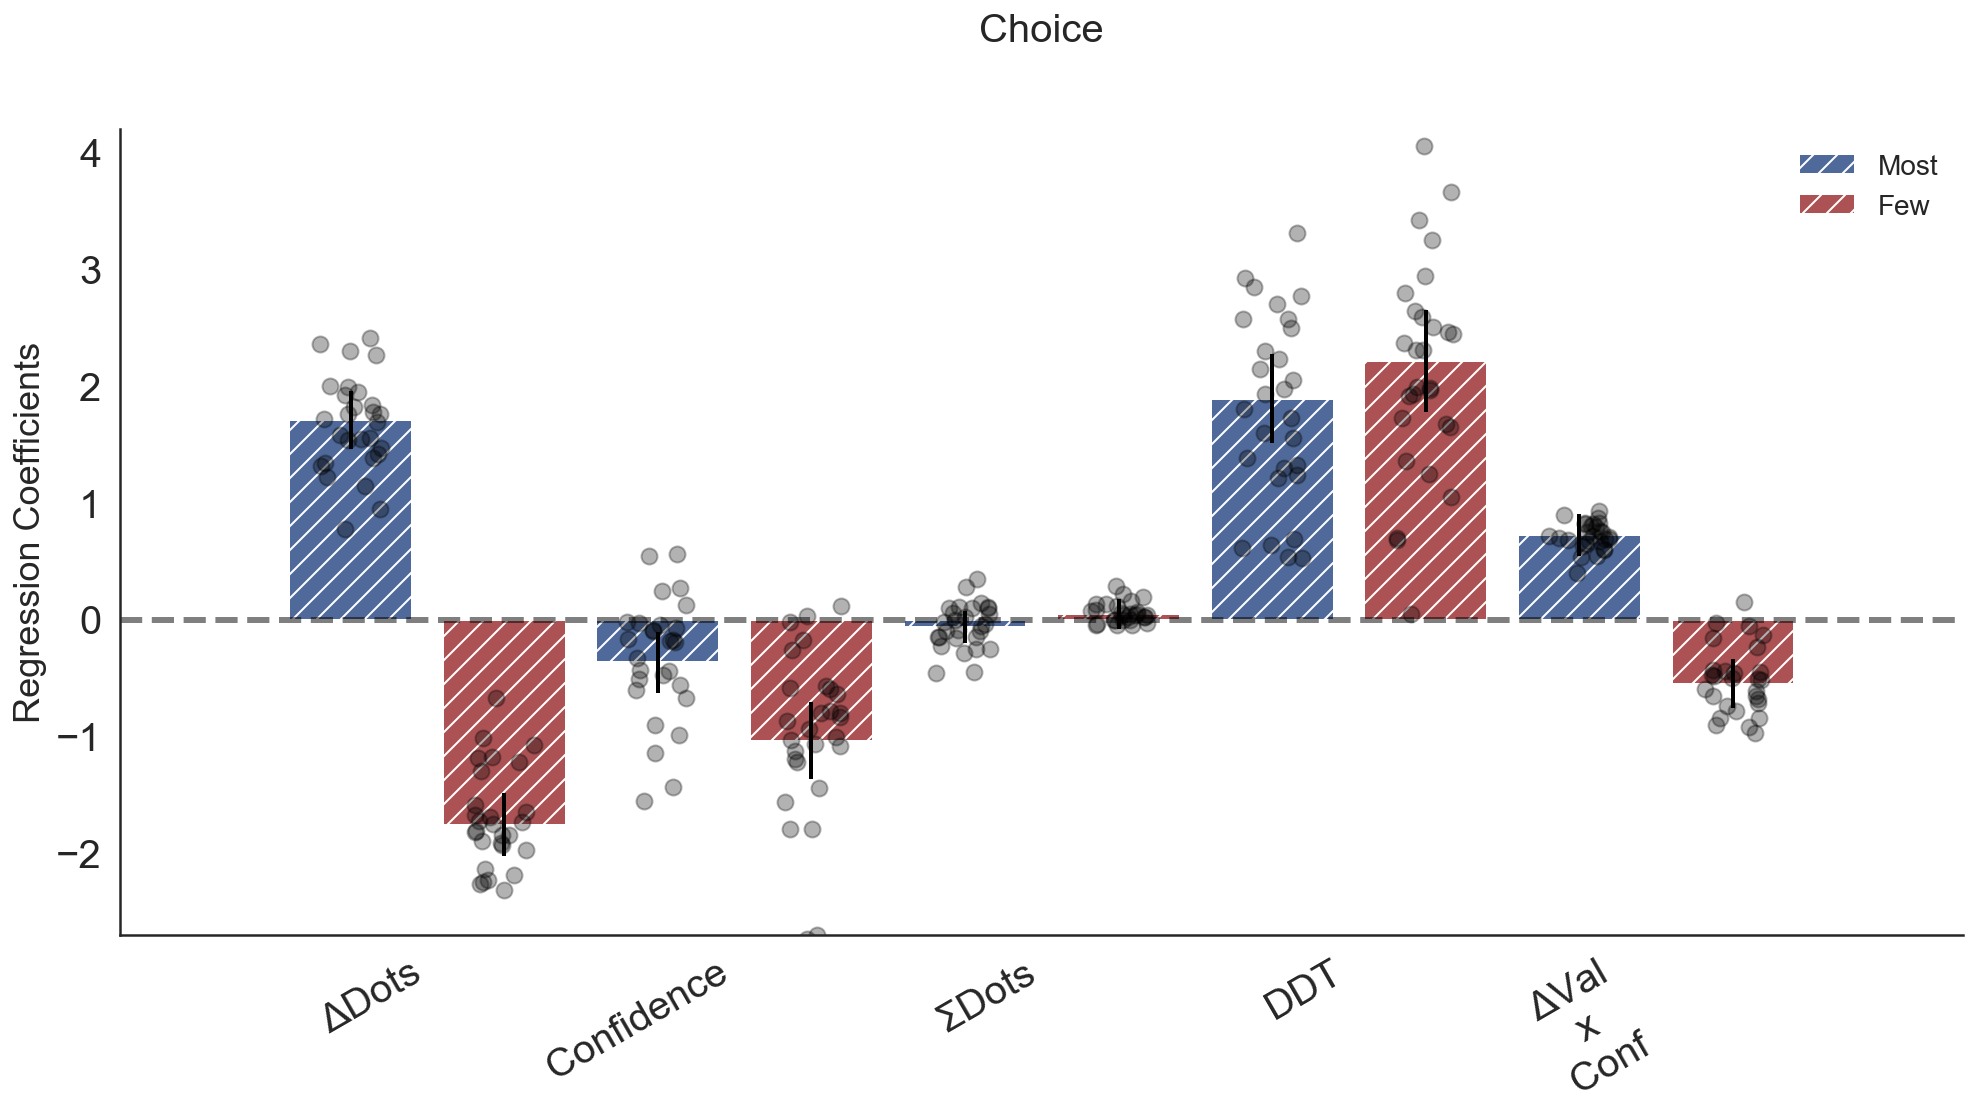

In [32]:
Coefpresplot_bar2(Choice_Like_hmodel_table, mix_Choice_Like_model,Choice_Dislike_hmodel_table, mix_Choice_Dislike_model, barcol1='#4F6A9A',barcol2='#AC5255', title='Choice', size='big',ymultiple=1, ticklabsize=20)
#plt.savefig('SavedFigures/Choice_Regression_Model.svg', format='svg', dpi = 500 )

ttestprint (Choice_Like_hmodel_table,Choice_Like_hmodel_table, mix_Choice_Like_model,mix_Choice_Dislike_model )


plt.xlim(0, 6)

plt.savefig(str('SavedFigures/PF2019ChoiceRegressionMoreLess_GlamEx_m2.png'), dpi = 200 )


### Save the results of the model

In [33]:
%%R
save(Choice_Like_hmodel, file = "SavedModels/Models_32Part/HModel_Choice_More_GlamEx_m2.rda")
save(Choice_Dislike_hmodel, file = "SavedModels/Models_32Part/HModel_Choice_Less_GlamEx_m2.rda")

## Confidence ~ BehavioralParams + GSF

### LESS condition model

In [34]:
%%R
# Fit the multilevel linear model
if (file.exists('SavedModels/Models_32Part/HModel_Confidence_Less_GlamEx_m2.rda')){
    load('SavedModels/Models_32Part/HModel_Confidence_Less_GlamEx_m2.rda')   
    print('  Found old parameter estimates in "SavedModels/". Skipping estimation...')
}
else{
    confidence_Dislike_hmodel <- lmer(zConf ~  zAbsDVal +zRT +  zTotVal + zGSF + ( zAbsDVal + zRT  + zTotVal + zGSF| Part), data=data_exp1_DisLike, control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    display (confidence_Dislike_hmodel)
}

lmer(formula = zConf ~ zAbsDVal + zRT + zTotVal + zGSF + (zAbsDVal + 
    zRT + zTotVal + zGSF | Part), data = data_exp1_DisLike, control = lmerControl(optimizer = "optimx", 
    optCtrl = list(method = "nlminb")))
            coef.est coef.se
(Intercept) -0.12     0.02  
zAbsDVal     0.15     0.02  
zRT         -0.23     0.04  
zTotVal     -0.17     0.03  
zGSF        -0.14     0.03  

Error terms:
 Groups   Name        Std.Dev. Corr                    
 Part     (Intercept) 0.08                             
          zAbsDVal    0.04     -0.70                   
          zRT         0.18      0.00 -0.72             
          zTotVal     0.10      0.10 -0.14  0.11       
          zGSF        0.09     -0.50 -0.15  0.69  0.54 
 Residual             0.93                             
---
number of obs: 3360, groups: Part, 28
AIC = 9202.2, DIC = 9105.6
deviance = 9132.9 


In [35]:
%%R

# Extract mixed effect paramters
mix_Confidence_Dislike_model <- coef(confidence_Dislike_hmodel)

## Estimating DFs and p-values
# get the coefficients for the best fitting model
coefs <- data.frame(coef(summary(confidence_Dislike_hmodel)))
coefs
# Use the Kenward-Roger approximation to get approximate degrees of freedom
df.KR <- get_ddf_Lb(confidence_Dislike_hmodel, fixef(confidence_Dislike_hmodel))
coefs$df.KR <-(rep(df.KR, each=4))

# Calculate confidence intervals from the estimates and the standard errors
coefs$semax <- coefs$Estimate + (coefs$Std..Error)
coefs$semin <- coefs$Estimate - (coefs$Std..Error)

# get p-values from the t-distribution using the t-values and approximated
# degrees of freedom
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))

# use normal distribution to approximate p-value (tends to be anti-conservative with small sample sizes)
coefs$p.z <- 2 * (1 - pnorm(abs(coefs$t.value)))


Error in `$<-.data.frame`(`*tmp*`, df.KR, value = c(26.8011468172564,  : 
  replacement has 4 rows, data has 5


In [36]:
%%R
coefs

              Estimate Std..Error   t.value
(Intercept) -0.1242778 0.02179182 -5.702956
zAbsDVal     0.1472686 0.02012332  7.318304
zRT         -0.2294615 0.04264884 -5.380252
zTotVal     -0.1684392 0.02636601 -6.388497
zGSF        -0.1350129 0.03007586 -4.489079


In [37]:
%%R
summary(confidence_Dislike_hmodel)

Linear mixed model fit by REML ['lmerMod']
Formula: zConf ~ zAbsDVal + zRT + zTotVal + zGSF + (zAbsDVal + zRT + zTotVal +  
    zGSF | Part)
   Data: data_exp1_DisLike
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 9160.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1902 -0.7075  0.0957  0.7466  3.0689 

Random effects:
 Groups   Name        Variance Std.Dev. Corr                   
 Part     (Intercept) 0.005755 0.07586                         
          zAbsDVal    0.001502 0.03876  -0.70                  
          zRT         0.032647 0.18068   0.00 -0.72            
          zTotVal     0.009632 0.09814   0.10 -0.14  0.11      
          zGSF        0.008875 0.09420  -0.50 -0.15  0.69  0.54
 Residual             0.862132 0.92851                         
Number of obs: 3360, groups:  Part, 28

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.12428    0.02179  -5.703
zAbsDVal     

In [38]:
#%%R 
#coef(confidence_Dislike_hmodel)

In [39]:
%R -o coefs -o mix_Confidence_Dislike_model
# extract
mix_Confidence_Dislike_model = mix_Confidence_Dislike_model[0]

conf_table_exp1 = coefs
conf_table_exp1

#Generate table with paramters to later plot
conf_table_exp1.columns = ['coefficient', 'se', 't' ]
conf_table_exp1 = conf_table_exp1.iloc[:, 0:-1].copy(); conf_table_exp1.loc[:, 'SEmax'] = conf_table_exp1['coefficient'] + conf_table_exp1['se']*2
conf_table_exp1.loc[:, 'SEmin'] = conf_table_exp1['coefficient'] - conf_table_exp1['se']*2
conf_table_exp1 = conf_table_exp1.transpose()
conf_table_exp1.columns = [ '(inter)','|ΔDots|', 'RT', 'ΣDots','GSF']
#conf_table_exp1.loc['p'] = np.round(conf_table_exp1.loc['p'], 4)
conf_table_exp1 = conf_table_exp1[['(inter)','|ΔDots|', 'RT', 'ΣDots','GSF']]
conf_table_Dislike = conf_table_exp1

conf_table_Dislike

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


,(inter),|ΔDots|,RT,ΣDots,GSF
coefficient,-0.124278,0.147269,-0.229462,-0.168439,-0.135013
se,0.021792,0.020123,0.042649,0.026366,0.030076
SEmax,-0.080694,0.187515,-0.144164,-0.115707,-0.074861
SEmin,-0.167861,0.107022,-0.314759,-0.221171,-0.195165


### MORE Condition

In [40]:
%%R
# Fit the multilevel linear model
if (file.exists('SavedModels/Models_32Part/HModel_Confidence_More_GlamEx_m2.rda')){
    print('  Found old parameter estimates in "SavedModels". Skipping estimation...')
    load('SavedModels/Models_32Part/HModel_Confidence_More_GlamEx_m2.rda')   
}
else{
confidence_Like_hmodel <- lmer(zConf ~  zAbsDVal +zRT +  zTotVal + zGSF + ( zAbsDVal + zRT  + zTotVal + zGSF| Part), data=data_exp1_Like, control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (confidence_Like_hmodel)
}

lmer(formula = zConf ~ zAbsDVal + zRT + zTotVal + zGSF + (zAbsDVal + 
    zRT + zTotVal + zGSF | Part), data = data_exp1_Like, control = lmerControl(optimizer = "optimx", 
    optCtrl = list(method = "nlminb")))
            coef.est coef.se
(Intercept)  0.11     0.02  
zAbsDVal     0.08     0.02  
zRT         -0.22     0.03  
zTotVal      0.04     0.02  
zGSF        -0.14     0.03  

Error terms:
 Groups   Name        Std.Dev. Corr                    
 Part     (Intercept) 0.08                             
          zAbsDVal    0.09     -0.27                   
          zRT         0.12      0.36 -0.49             
          zTotVal     0.05      0.96 -0.47  0.54       
          zGSF        0.14     -0.07  0.39 -0.46 -0.30 
 Residual             0.86                             
---
number of obs: 3360, groups: Part, 28
AIC = 8658.5, DIC = 8559.6
deviance = 8588.0 


In [41]:
%%R

# Extract mixed effect paramters
mix_Confidence_Like_model <- coef(confidence_Like_hmodel)

## Estimating DFs and p-values
# get the coefficients for the best fitting model
coefs <- data.frame(coef(summary(confidence_Like_hmodel)))
coefs
# Use the Kenward-Roger approximation to get approximate degrees of freedom
df.KR <- get_ddf_Lb(confidence_Like_hmodel, fixef(confidence_Like_hmodel))
coefs$df.KR <-(rep(df.KR, each=4))

# Calculate confidence intervals from the estimates and the standard errors
coefs$semax <- coefs$Estimate + (coefs$Std..Error)
coefs$semin <- coefs$Estimate - (coefs$Std..Error)

# get p-values from the t-distribution using the t-values and approximated
# degrees of freedom
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))

# use normal distribution to approximate p-value (tends to be anti-conservative with small sample sizes)
coefs$p.z <- 2 * (1 - pnorm(abs(coefs$t.value)))


Error in `$<-.data.frame`(`*tmp*`, df.KR, value = c(26.8559650436636,  : 
  replacement has 4 rows, data has 5


In [42]:
%%R
summary(confidence_Like_hmodel)

Linear mixed model fit by REML ['lmerMod']
Formula: zConf ~ zAbsDVal + zRT + zTotVal + zGSF + (zAbsDVal + zRT + zTotVal +  
    zGSF | Part)
   Data: data_exp1_Like
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 8616.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9637 -0.6187  0.1038  0.6952  3.0153 

Random effects:
 Groups   Name        Variance Std.Dev. Corr                   
 Part     (Intercept) 0.006115 0.07820                         
          zAbsDVal    0.008189 0.09049  -0.27                  
          zRT         0.014869 0.12194   0.36 -0.49            
          zTotVal     0.002085 0.04566   0.96 -0.47  0.54      
          zGSF        0.018900 0.13748  -0.07  0.39 -0.46 -0.30
 Residual             0.733833 0.85664                         
Number of obs: 3360, groups:  Part, 28

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.10988    0.02110   5.208
zAbsDVal     0.0

In [43]:
%%R
coefs

               Estimate Std..Error   t.value
(Intercept)  0.10988295 0.02109859  5.208071
zAbsDVal     0.08316192 0.02440253  3.407923
zRT         -0.22227637 0.03192355 -6.962772
zTotVal      0.04094033 0.01935908  2.114787
zGSF        -0.14423072 0.03403954 -4.237153


In [44]:
%R -o coefs -o mix_Confidence_Like_model

mix_Confidence_Like_model = mix_Confidence_Like_model[0]

conf_table_exp1 = coefs
conf_table_exp1

#Generate table with paramters to later plot
conf_table_exp1.columns = ['coefficient', 'se', 't' ]
conf_table_exp1 = conf_table_exp1.iloc[:, 0:-1].copy(); conf_table_exp1.loc[:, 'SEmax'] = conf_table_exp1['coefficient'] + conf_table_exp1['se']*2
conf_table_exp1.loc[:, 'SEmin'] = conf_table_exp1['coefficient'] - conf_table_exp1['se']*2
conf_table_exp1 = conf_table_exp1.transpose()
conf_table_exp1.columns = [ '(inter)','|ΔDots|', 'RT', 'ΣDots','GSF']
#conf_table_exp1.loc['p'] = np.round(conf_table_exp1.loc['p'], 4)
conf_table_exp1 = conf_table_exp1[['(inter)','|ΔDots|','RT', 'ΣDots','GSF']]
conf_table_Like = conf_table_exp1
conf_table_Like

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


,(inter),|ΔDots|,RT,ΣDots,GSF
coefficient,0.109883,0.083162,-0.222276,0.040940,-0.144231
se,0.021099,0.024403,0.031924,0.019359,0.034040
SEmax,0.152080,0.131967,-0.158429,0.079658,-0.076152
SEmin,0.067686,0.034357,-0.286123,0.002222,-0.212310


### Plotting both conditions

Mismatch
---------------- SIGNIFICANT FACTOR ----------------------
(inter) : MeanL = 0.11; t =  9.9 ; p-value =0.0**
(inter) : MeanD = -0.12; t =  -12.63 ; p-value =0.0**
|ΔDots| : MeanL = 0.08; t =  6.45 ; p-value =0.0**
|ΔDots| : MeanD = 0.15; t =  25.97 ; p-value =0.0**
RT : MeanL = -0.22; t =  -12.64 ; p-value =0.0**
RT : MeanD = -0.23; t =  -7.31 ; p-value =0.0**
ΣDots : MeanL = 0.04; t =  6.11 ; p-value =0.0**
ΣDots : MeanD = -0.17; t =  -11.78 ; p-value =0.0**
GSF : MeanL = -0.14; t =  -7.06 ; p-value =0.0**
GSF : MeanD = -0.14; t =  -8.51 ; p-value =0.0**
---------------- COMPARE [ LIKE - DISLIKE ] ----------------------
(inter) : MeanL = 0.11; MeanD = -0.12; [Like - Dislike] =  0.0; t =  11.51 ; p-value =0.0**
|ΔDots| : MeanL = 0.08; MeanD = 0.15; [Like - Dislike] =  -0.0; t =  -4.38 ; p-value =0.0**
RT : MeanL = -0.22; MeanD = -0.23; [Like - Dislike] =  0.0; t =  0.22 ; p-value =0.83
ΣDots : MeanL = 0.04; MeanD = -0.17; [Like - Dislike] =  0.0; t =  12.61 ; p-value =0.0**
GS

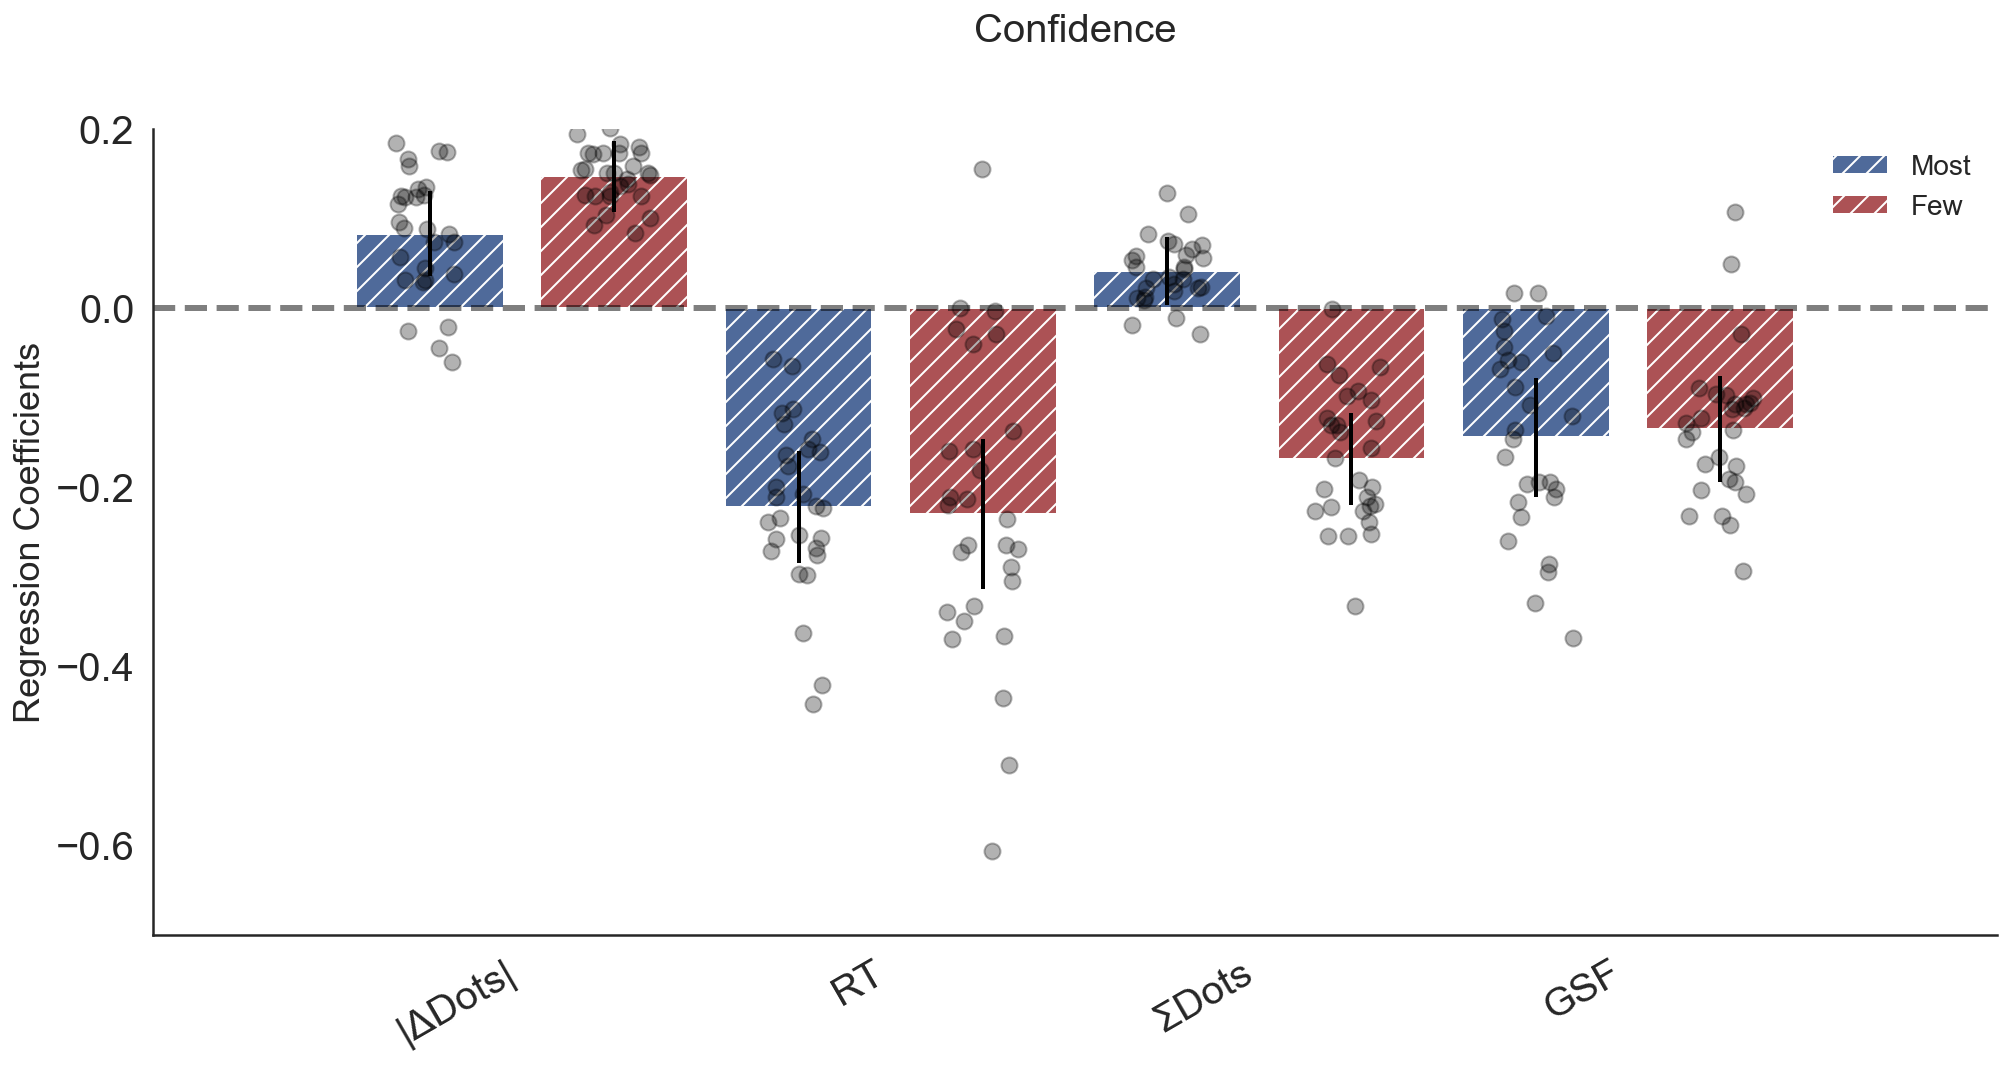

In [45]:
Coefpresplot_bar2(conf_table_Like, mix_Confidence_Like_model,conf_table_Dislike, mix_Confidence_Dislike_model, barcol1='#4F6A9A',barcol2='#AC5255', title='Confidence', size='big',ymultiple=0.2, ticklabsize=20)
ttestprint (conf_table_Like,conf_table_Dislike, mix_Confidence_Like_model,mix_Confidence_Dislike_model )
plt.xlim(0, 5)
plt.savefig(str('SavedFigures/PF2019ConfidenceRegressionMoreLess_GlamEx_m2.png'), dpi = 200 )


### Save the results of the model

In [46]:
%%R
save(confidence_Like_hmodel, file = "SavedModels/Models_32Part/HModel_Confidence_More_GlamEx_m2.rda")
save(confidence_Dislike_hmodel, file = "SavedModels/Models_32Part/HModel_Confidence_Less_GlamEx_m2.rda")